In [1]:
import sys
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from pandas import datetime
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.api import ExponentialSmoothing, ARIMA, ARMA, arma_order_select_ic
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

In [2]:
# 设置图片参数
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['figure.figsize'] = (15, 8)  # 图片大小
plt.rcParams['savefig.dpi'] = 300  # 图片像素
# plt.rcParams['figure.dpi'] = 300  # 分辨率

In [3]:
def error_prop(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

In [4]:
def parse_date(str):
    return datetime.strptime(str, '%Y-%m-%d')

## 1 数据预处理

In [5]:
# 加载数据
data_path = "../../data/luggage_compartment_door.txt"
df = pd.read_csv(data_path, sep='\t')

In [6]:
# 重新命名列名
df.rename(columns={'物料编码': 'part_id', '物料描述': 'part_name', 
                   '订货数': 'order_num', '缺件数': 'out_of_stock_num', 
                   '受理数': 'delivery_num', '审核日期': 'date', '审核时间': 'time'}, inplace=True)

In [7]:
# 将`part_id`的数据类型设为字符串，方便后面进行重采样 
df['part_id'] = df['part_id'].astype('str')

In [8]:
# 重置索引
# df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df['date'] = df['date'].apply(parse_date)
df.set_index('date', inplace=True)

In [12]:
# 按照时间排序
df.sort_index(inplace=True)

In [14]:
# 采样
df_day = df.resample('D').sum()

In [24]:
df_day['week'] = df_day.index.week

In [32]:
df_2015 = df_day['2015']
len(df_2015)

362

In [33]:
df_2016 = df_day['2016']
len(df_2016)

366

In [30]:
df_2017 = df_day['2017']
len(df_2017)

365

In [31]:
df_2018 = df_day['2018']
len(df_2018)

269

In [36]:
df_2015['week'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53], dtype=int64)

In [37]:
df_2016['week'].unique()

array([53,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52], dtype=int64)

In [38]:
df_2017['week'].unique()

array([52,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51], dtype=int64)

In [39]:
df_2018['week'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39], dtype=int64)

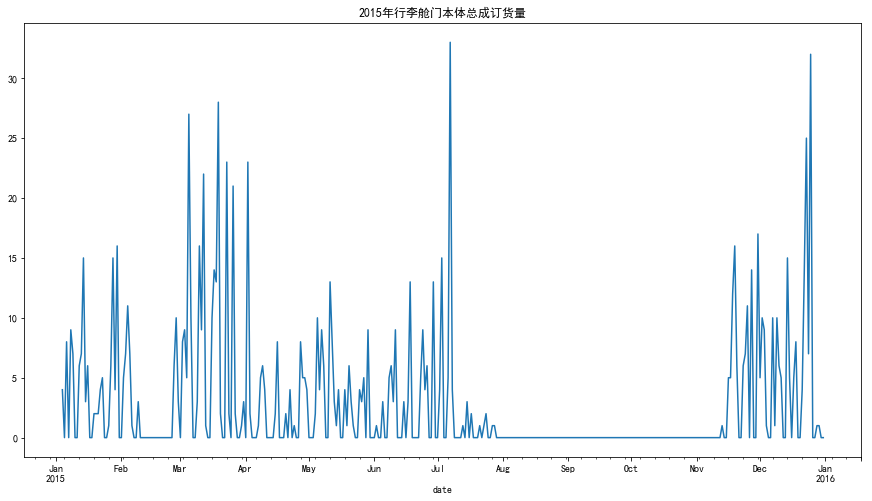

In [55]:
df_2015.order_num.plot(title='2015年行李舱门本体总成订货量')

In [63]:
df_2016.order_num.mean()

7.948087431693989

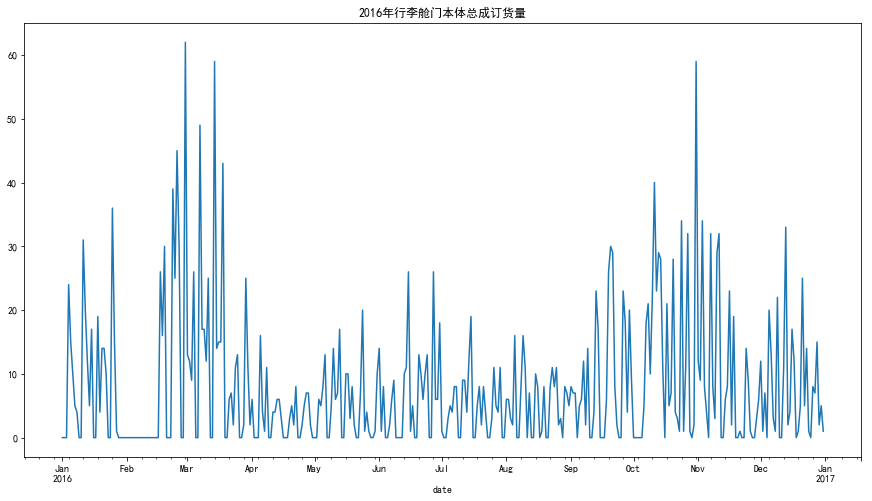

In [56]:
df_2016.order_num.plot(title='2016年行李舱门本体总成订货量')

In [64]:
df_2017.order_num.mean()

11.452054794520548

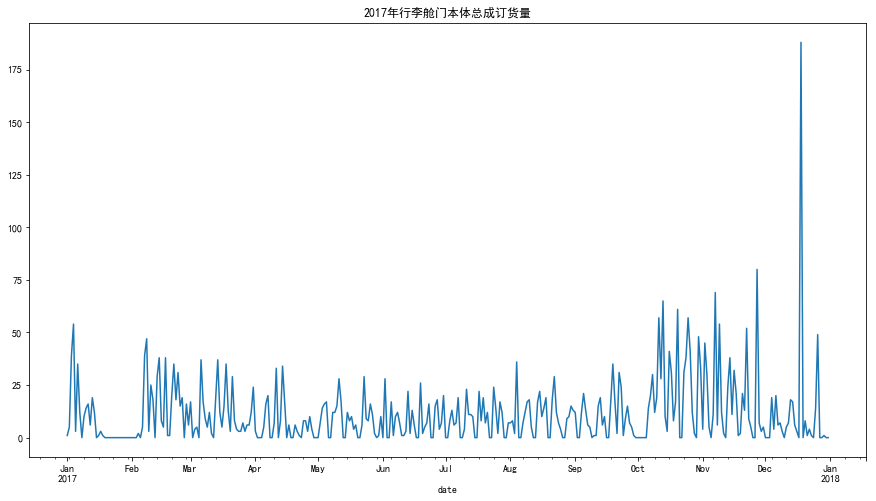

In [57]:
df_2017.order_num.plot(title='2017年行李舱门本体总成订货量')

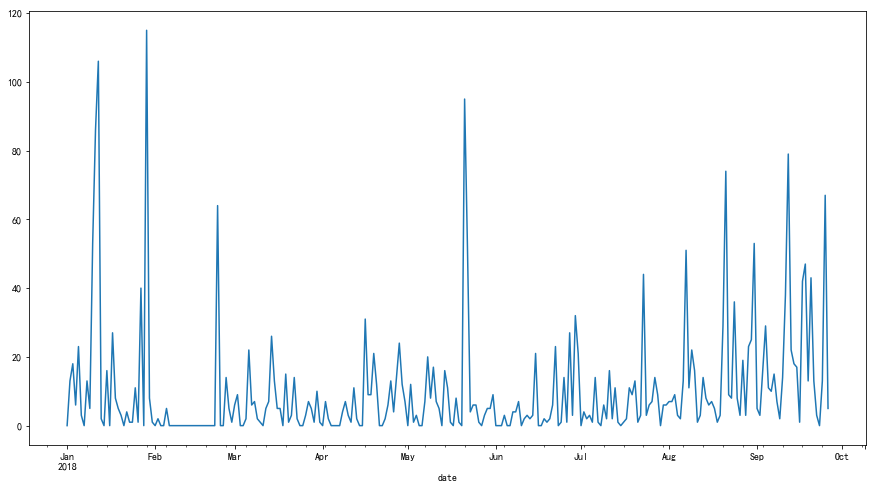

In [76]:
df_2018.order_num.plot()

In [77]:
df_2018['month'] = df_2018.index.month

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [83]:
df_201804_to_201806 = df_2018[(df_2018['month'] >= 4) & (df_2018['month'] <= 6)]

In [89]:
df_201804_to_201806_month = df_201804_to_201806[['order_num', 'out_of_stock_num', 'delivery_num']].resample('M').sum()

In [93]:
df_201804_to_201806_week = df_201804_to_201806[['order_num', 'out_of_stock_num', 'delivery_num']].resample('W').sum()

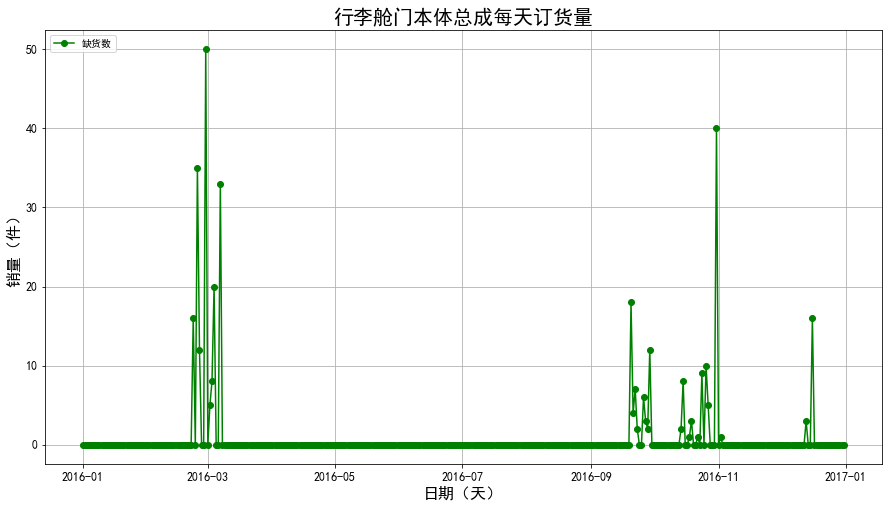

In [99]:
fig, ax = plt.subplots()
# ax.plot(df_2018.order_num, 'ro-', label='订货数')
ax.plot(df_2016.out_of_stock_num, 'go-', label='缺货数')
# ax.plot(df_2018.delivery_num, 'bo-', label='受理数')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('行李舱门本体总成每天订货量', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

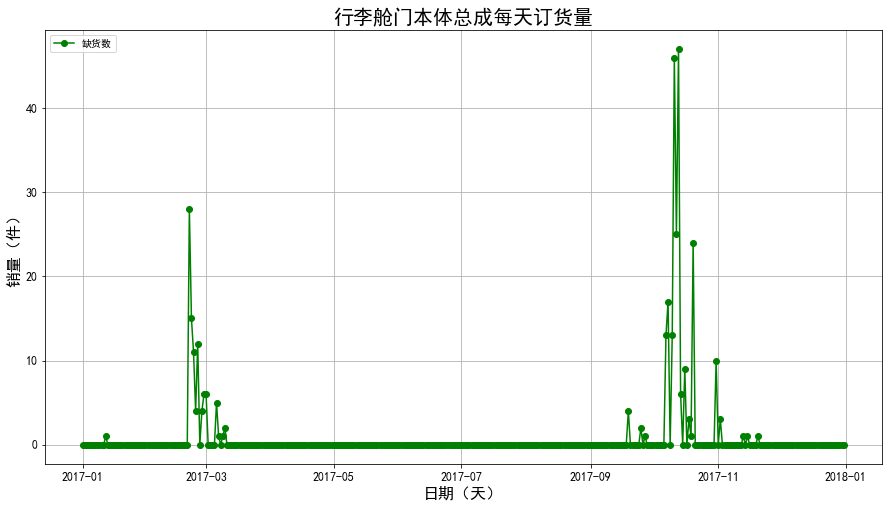

In [98]:
fig, ax = plt.subplots()
# ax.plot(df_2018.order_num, 'ro-', label='订货数')
ax.plot(df_2017.out_of_stock_num, 'go-', label='缺货数')
# ax.plot(df_2018.delivery_num, 'bo-', label='受理数')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('行李舱门本体总成每天订货量', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [100]:
df_201702_to_201704 = df_2017['2017-02':'2017-04']

In [115]:
df_201702_to_201704_week = df_201702_to_201704.resample('W').sum()

In [119]:
df_201702_to_201704_week

,order_num,out_of_stock_num,delivery_num,week
date,,,,
2017-02-05,2.0,0.0,2.0,25
2017-02-12,137.0,0.0,137.0,42
2017-02-19,120.0,0.0,120.0,49
2017-02-26,138.0,70.0,68.0,56
2017-03-05,48.0,16.0,32.0,63
2017-03-12,82.0,9.0,73.0,70
2017-03-19,136.0,0.0,136.0,77
2017-03-26,57.0,0.0,57.0,84
2017-04-02,54.0,0.0,54.0,91


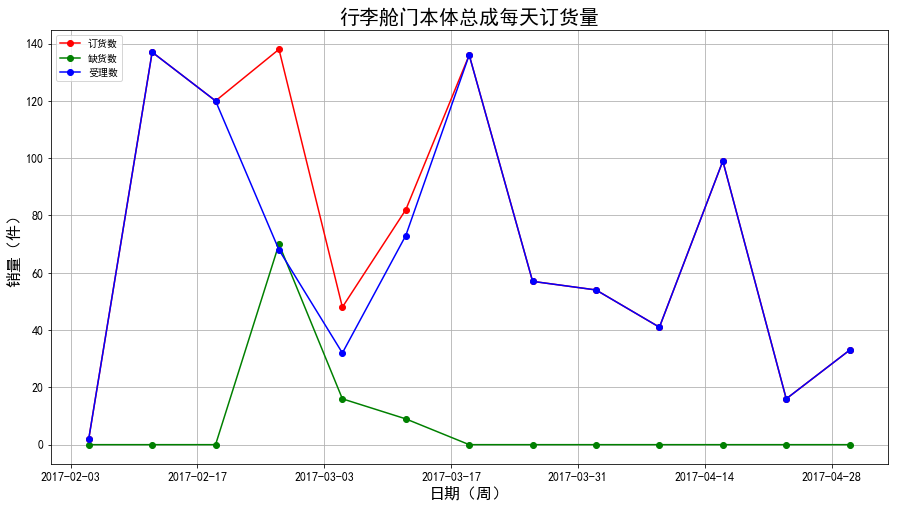

In [117]:
fig, ax = plt.subplots()
ax.plot(df_201702_to_201704_week.order_num, 'ro-', label='订货数')
ax.plot(df_201702_to_201704_week.out_of_stock_num, 'go-', label='缺货数')
ax.plot(df_201702_to_201704_week.delivery_num, 'bo-', label='受理数')
ax.set_xlabel('日期（周）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('行李舱门本体总成每天订货量', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [105]:
df_20170221_to_20170321 = df_2017['2017-02-21':'2017-03-21']

In [114]:
len(df_20170221_to_20170321)

29

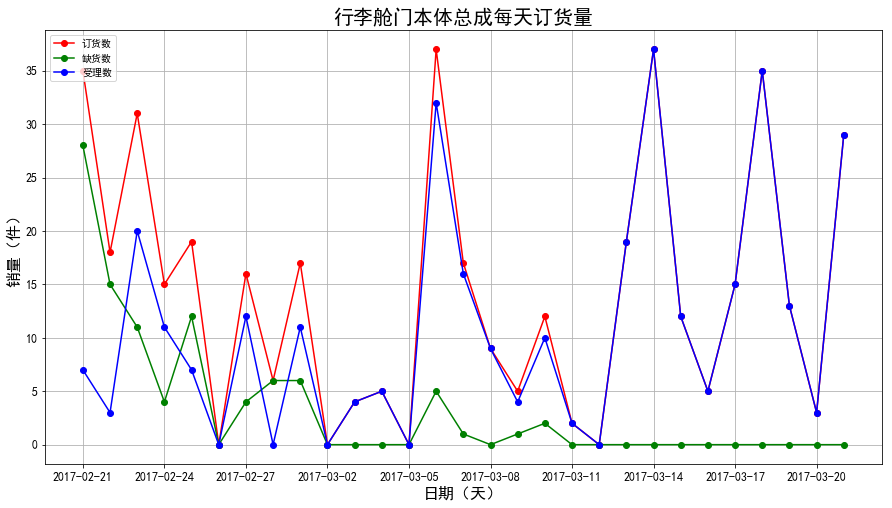

In [113]:
fig, ax = plt.subplots()
ax.plot(df_20170221_to_20170321.order_num, 'ro-', label='订货数')
ax.plot(df_20170221_to_20170321.out_of_stock_num, 'go-', label='缺货数')
ax.plot(df_20170221_to_20170321.delivery_num, 'bo-', label='受理数')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('行李舱门本体总成每天订货量', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [122]:
df_2017_week = df_2017[['order_num', 'out_of_stock_num', 'delivery_num']].resample('W').sum()

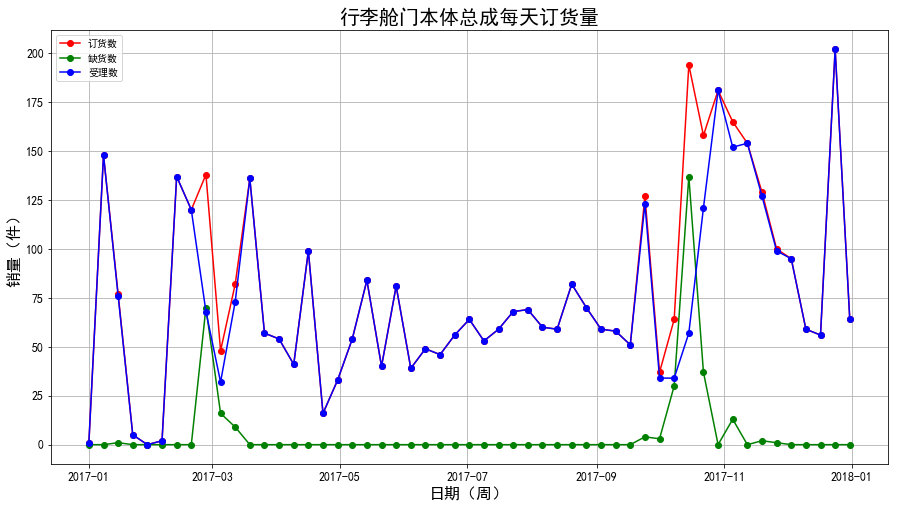

In [124]:
fig, ax = plt.subplots()
ax.plot(df_2017_week.order_num, 'ro-', label='订货数')
ax.plot(df_2017_week.out_of_stock_num, 'go-', label='缺货数')
ax.plot(df_2017_week.delivery_num, 'bo-', label='受理数')
ax.set_xlabel('日期（周）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('行李舱门本体总成每天订货量', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

2017年9月到10月

In [128]:
df_201709_to_201710 = df_2017['2017-09':'2017-10']

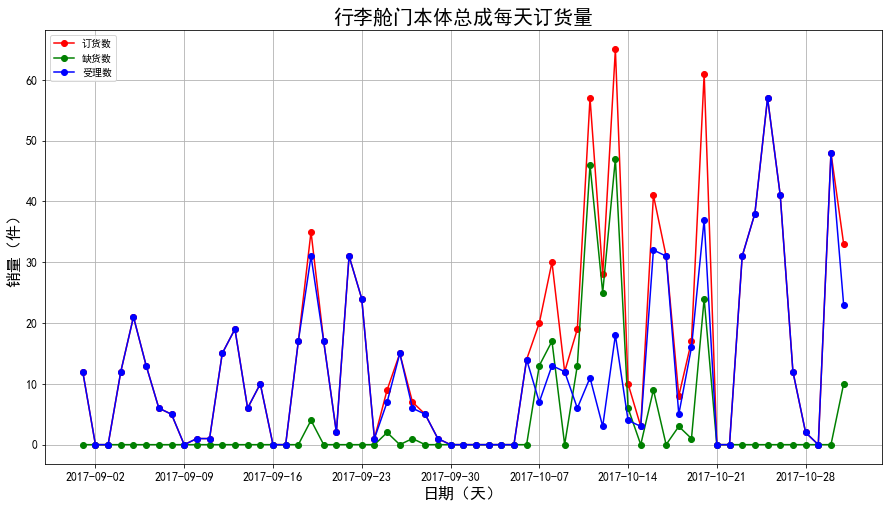

In [130]:
fig, ax = plt.subplots()
ax.plot(df_201709_to_201710.order_num, 'ro-', label='订货数')
ax.plot(df_201709_to_201710.out_of_stock_num, 'go-', label='缺货数')
ax.plot(df_201709_to_201710.delivery_num, 'bo-', label='受理数')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('行李舱门本体总成每天订货量', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

2017年10月5日到2017年10月28日

In [131]:
df_20171005_to_20171028 = df_2017['2017-10-05':'2017-10-28']

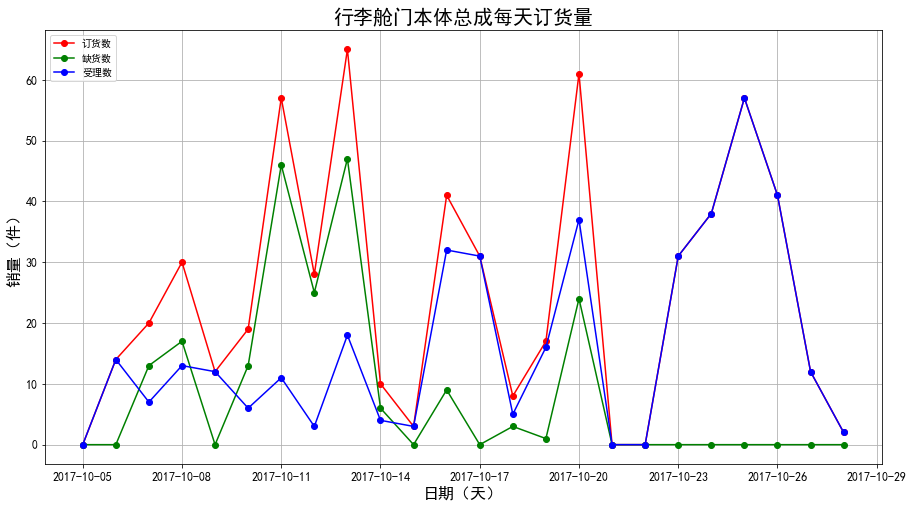

In [134]:
fig, ax = plt.subplots()
ax.plot(df_20171005_to_20171028.order_num, 'ro-', label='订货数')
ax.plot(df_20171005_to_20171028.out_of_stock_num, 'go-', label='缺货数')
ax.plot(df_20171005_to_20171028.delivery_num, 'bo-', label='受理数')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('行李舱门本体总成每天订货量', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [136]:
df_20171005_to_20171028_week = df_20171005_to_20171028[['order_num', 'out_of_stock_num', 'delivery_num']].resample('W').sum()

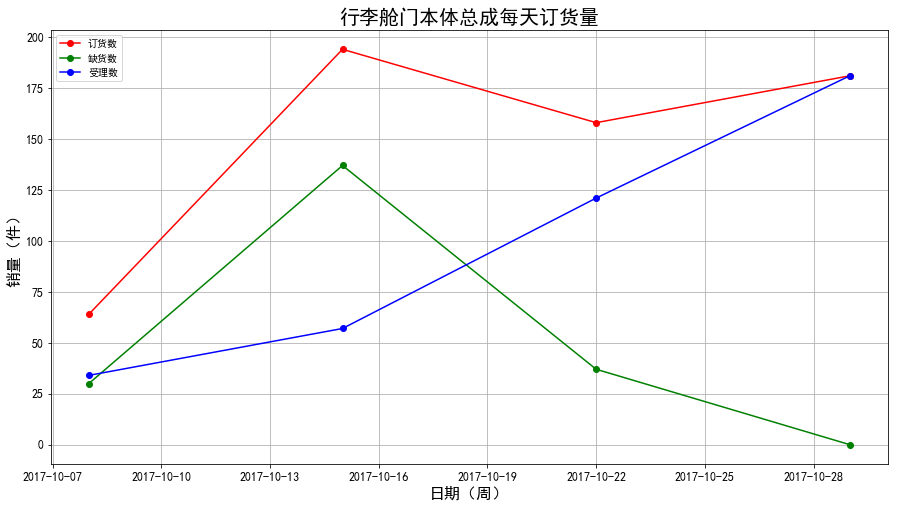

In [137]:
fig, ax = plt.subplots()
ax.plot(df_20171005_to_20171028_week.order_num, 'ro-', label='订货数')
ax.plot(df_20171005_to_20171028_week.out_of_stock_num, 'go-', label='缺货数')
ax.plot(df_20171005_to_20171028_week.delivery_num, 'bo-', label='受理数')
ax.set_xlabel('日期（周）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('行李舱门本体总成每天订货量', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

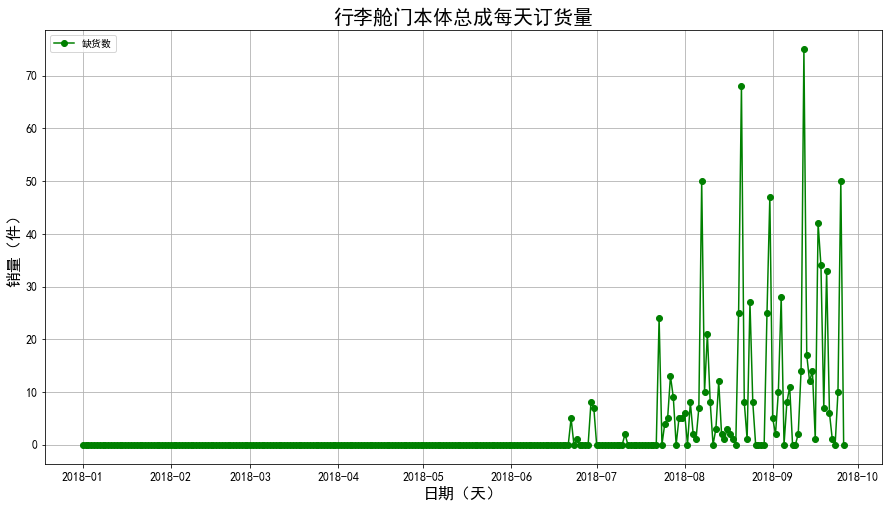

In [96]:
fig, ax = plt.subplots()
# ax.plot(df_2018.order_num, 'ro-', label='订货数')
ax.plot(df_2018.out_of_stock_num, 'go-', label='缺货数')
# ax.plot(df_2018.delivery_num, 'bo-', label='受理数')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('行李舱门本体总成每天订货量', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

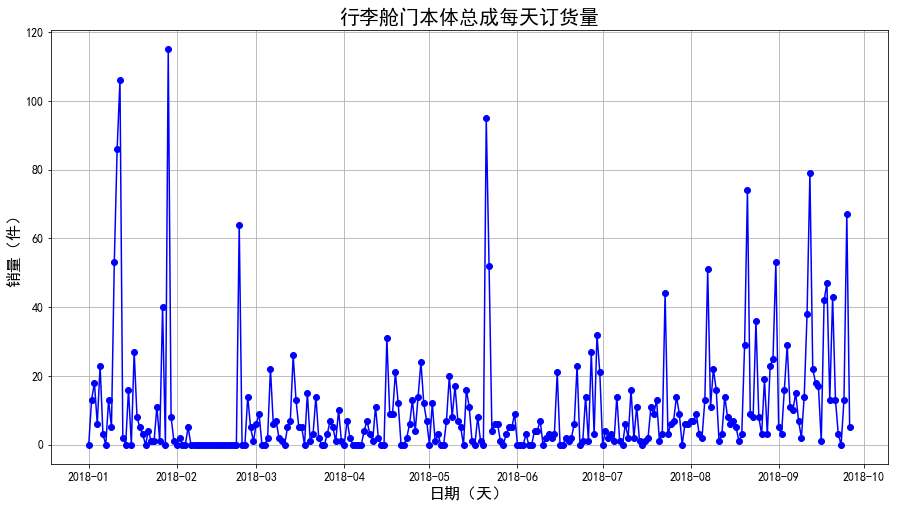

In [75]:
# df_2018.order_num.plot(title='2018年行李舱门本体总成订货量')

# fig, ax = plt.subplots()
# ax.plot(df_day.index, df_day.order_num.values, 'bo-')
# ax.set_xlabel('日期（天）', fontsize=16)
# ax.set_ylabel('销量（件）', fontsize=16)
# ax.set_title('行李舱门本体总成每天订货量', fontsize=20)
# ax.grid()

fig, ax = plt.subplots()
ax.plot(df_2018.index, df_2018.order_num, 'bo-')
ax.plot()
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('行李舱门本体总成每天订货量', fontsize=20)
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [139]:
df_2018_week = df_2018[['order_num', 'out_of_stock_num', 'delivery_num']].resample('W').sum()

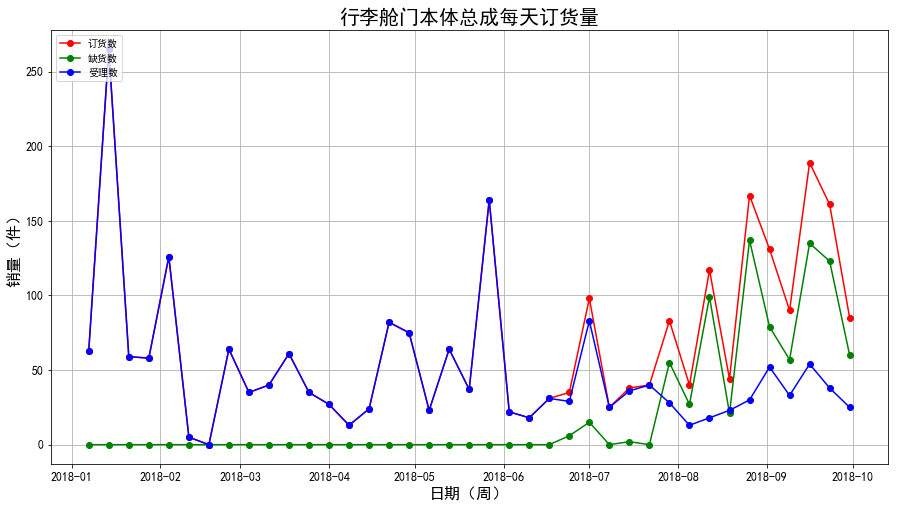

In [140]:
fig, ax = plt.subplots()
ax.plot(df_2018_week.order_num, 'ro-', label='订货数')
ax.plot(df_2018_week.out_of_stock_num, 'go-', label='缺货数')
ax.plot(df_2018_week.delivery_num, 'bo-', label='受理数')
ax.set_xlabel('日期（周）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('行李舱门本体总成每天订货量', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [7]:
train_day = df_day[:-60]
test_day = df_day[-60:]

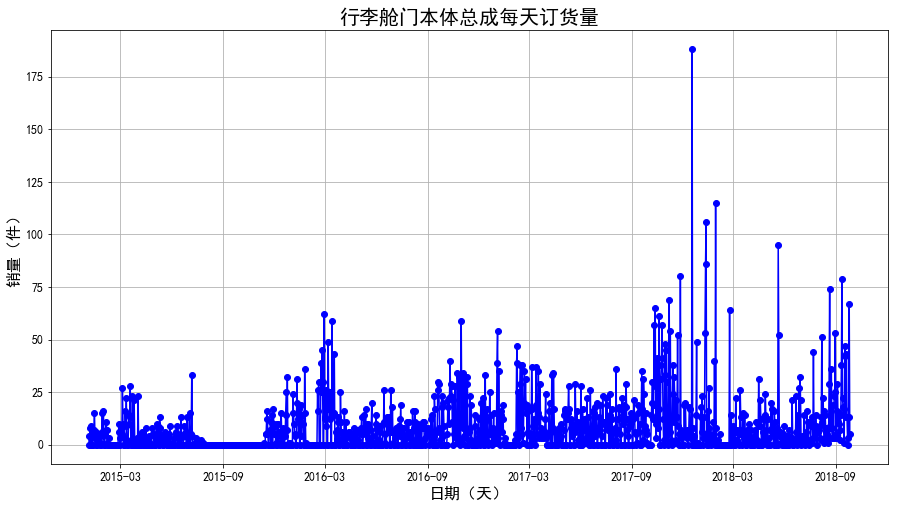

In [8]:
fig, ax = plt.subplots()
ax.plot(df_day.index, df_day.order_num.values, 'bo-')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('行李舱门本体总成每天订货量', fontsize=20)
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## 2 时间序列检验

### 2.1 自相关图和偏自相关图

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


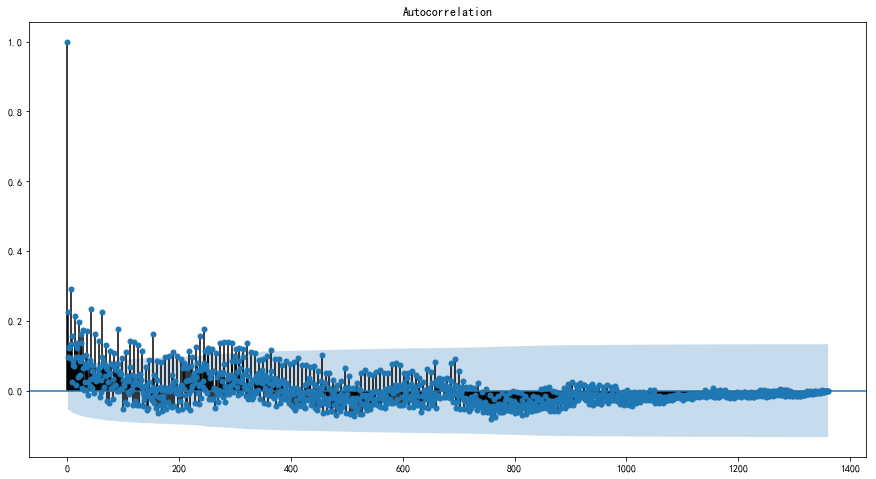

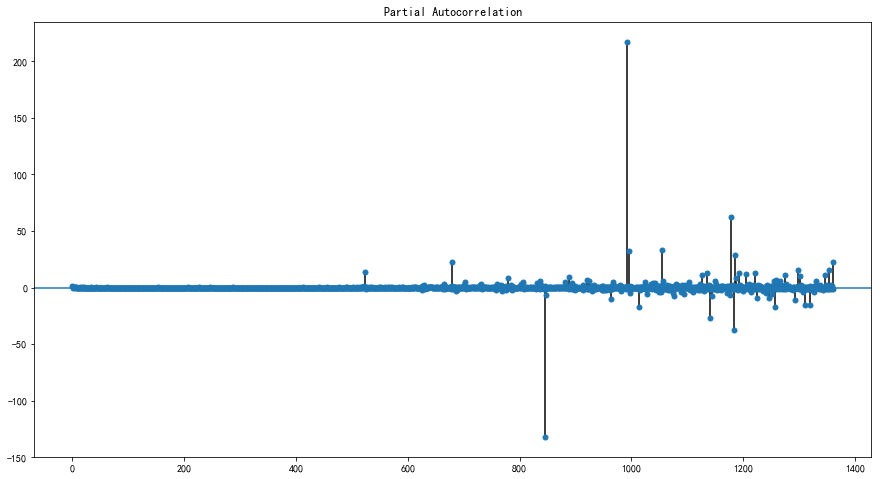

In [9]:
# 天的自相关图
plot_acf(df_day.order_num.values).show()
plot_pacf(df_day.order_num.values).show()

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


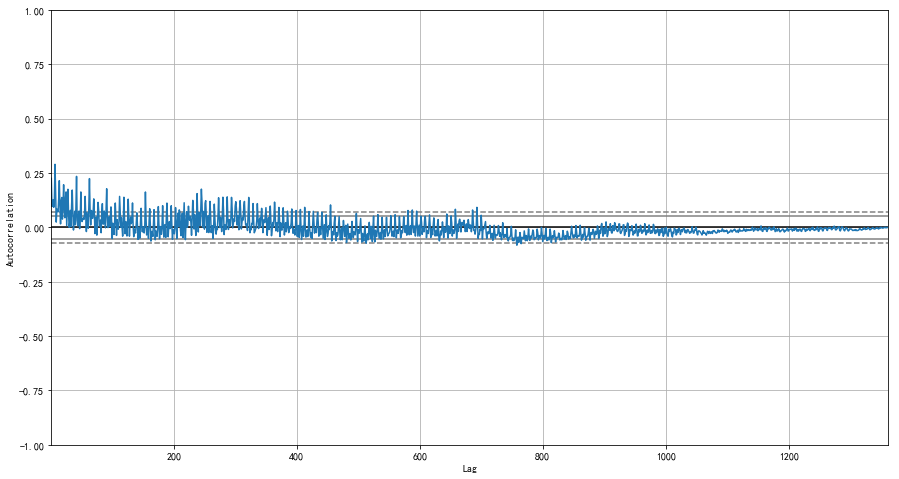

In [10]:
autocorrelation_plot(df_day.order_num.values)
plt.show()

### 2.2 单位根检验

In [11]:
adf_result = adfuller(df_day.order_num.values)
output = pd.DataFrame(index=["Test Statistic Value", "p-value", "Lags Used", "Number of Observations Used", "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"], columns=['value'])
output['value']['Test Statistic Value'] = adf_result[0]
output['value']['p-value'] = adf_result[1]
output['value']['Lags Used'] = adf_result[2]
output['value']['Number of Observations Used'] = adf_result[3]
output['value']['Critical Value (1%)'] = adf_result[4]['1%']
output['value']['Critical Value (5%)'] = adf_result[4]['5%']
output['value']['Critical Value (10%)'] = adf_result[4]['10%']
print("单位根检验结果为：")
print(output)

单位根检验结果为：
                                 value
Test Statistic Value          -3.36652
p-value                      0.0121547
Lags Used                           24
Number of Observations Used       1337
Critical Value (1%)           -3.43525
Critical Value (5%)            -2.8637
Critical Value (10%)          -2.56792


### 2.3 纯随机性检验

In [12]:
print("序列的纯随机性检验结果为：", end='')
print(acorr_ljungbox(df_day.order_num.values, lags=1)[1][0])

序列的纯随机性检验结果为：8.784482240114542e-17


## 3 模型拟合

### 3.1 Holt-Winters method

In [26]:
train, test = train_day.order_num.values, test_day.order_num.values

In [29]:
model = ExponentialSmoothing(train, seasonal_periods=7, trend='add', seasonal='add')
model_fit = model.fit()
preds = model_fit.forecast(60)

In [47]:
decomposition = seasonal_decompose(train_day.order_num, model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

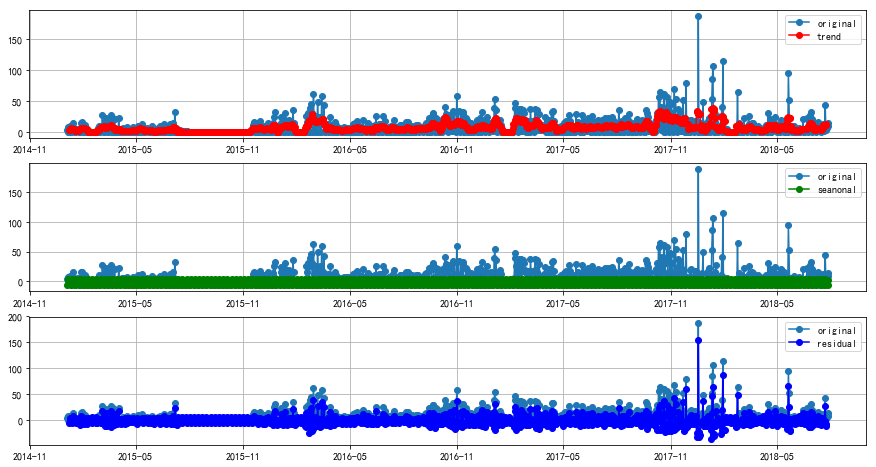

In [50]:
# fig, ax = plt.subplots()
# ax.plot(trend, 'ro-', label='trend')
# ax.plot(seasonal, 'go-', label='seanonal')
# ax.plot(residual, 'bo-', label='residual')

plt.subplot(3, 1, 1)
plt.plot(train_day.order_num, 'o-', label='original')
plt.plot(trend, 'ro-', label='trend')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(train_day.order_num, 'o-', label='original')
plt.plot(seasonal, 'go-', label='seanonal')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(train_day.order_num, 'o-', label='original')
plt.plot(residual, 'bo-', label='residual')
plt.legend()
plt.grid()

plt.show()

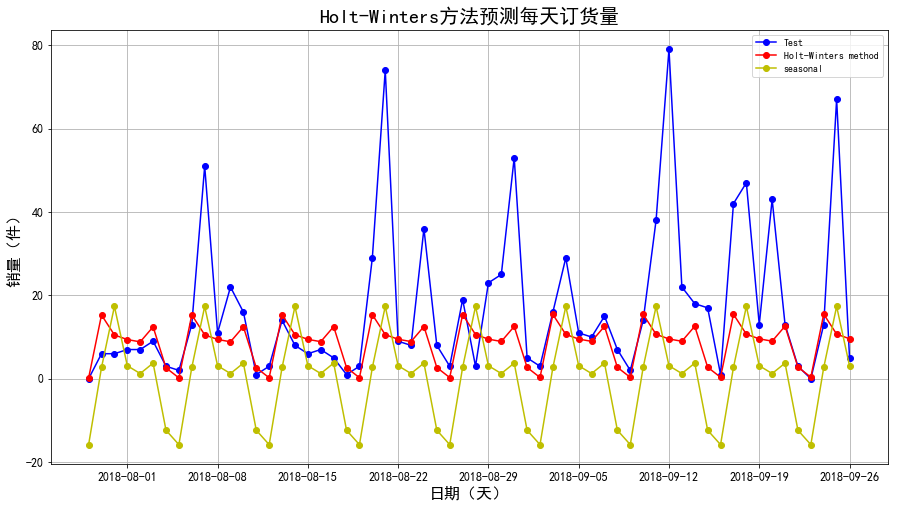

In [46]:
fig, ax = plt.subplots()
# ax.plot(train_day.index, train_day.order_num.values, 'go-', label='Train')
ax.plot(test_day.index, test, 'bo-', label='Test')
ax.plot(test_day.index, preds, 'ro-', label='Holt-Winters method')
ax.plot(seasonal, 'yo-', label='seasonal')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('Holt-Winters方法预测每天订货量', fontsize=20)
ax.legend(loc='best')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [16]:
rmse = sqrt(mean_squared_error(test, preds))
print("The RMSE of 'Holt-Winters method' is:", rmse)

The RMSE of 'Holt-Winters method' is: 19.040754212445126


In [17]:
print("The error proportion of Holt-Winters is:", error_prop(test, preds))

The error proportion of Holt-Winters is: 0.6178165824384354


### 3.2 ARIMA

In [18]:
train, test = train_day.order_num.values, test_day.order_num.values

In [19]:
# pmax = len(df_day) // 10
# qmax = len(df_day) // 10 

pmax = 6
qmax = 6

bic_matrix = [] 
for p in range(pmax + 1):
    temp = []
    for q in range(qmax + 1):
        try: 
            temp.append(ARIMA(train, (p, 0, q)).fit().aic)
        except:
            temp.append(None)
    bic_matrix.append(temp)

bic_matrix = pd.DataFrame(bic_matrix).astype('float').dropna(axis=1)
p, q = bic_matrix.stack().idxmin()
print("AIC最小的(p, q)值为：(%s, %s)" % (p, q))

bic_matrix = [] 
for p in range(pmax + 1):
    temp = []
    for q in range(qmax + 1):
        try: 
            temp.append(ARIMA(train, (p, 0, q)).fit().aic)
        except:
            temp.append(None)
    bic_matrix.append(temp)

bic_matrix = pd.DataFrame(bic_matrix).astype('float').dropna(axis=1)
p, q = bic_matrix.stack().idxmin()
print("AIC最小的(p, q)值为：(%s, %s)" % (p, q))

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC最小的(p, q)值为：(6, 5)


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC最小的(p, q)值为：(6, 5)


In [21]:
arma_order_select_ic(train, max_ar=6, max_ma=6, ic='aic')['aic_min_order']

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np

(5, 5)

In [21]:
history = list(train)
preds = list()
for i in range(len(test)):
    model = ARMA(history, order=(4, 3))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    preds.append(yhat[0])
    obs = test[i]
    history.append(obs)
    print("expected = %f predicted = %f" % (obs, yhat))
error = sqrt(mean_squared_error(test, preds))
print("Test RMSE: %.3f" % error)

expected = 0.000000 predicted = 5.289614
expected = 6.000000 predicted = 11.469692
expected = 6.000000 predicted = 8.107044
expected = 7.000000 predicted = 2.162884
expected = 7.000000 predicted = 8.907801
expected = 9.000000 predicted = 11.752047
expected = 3.000000 predicted = 4.310658
expected = 2.000000 predicted = 3.926309
expected = 13.000000 predicted = 11.068245
expected = 51.000000 predicted = 8.874346
expected = 11.000000 predicted = 9.686771
expected = 22.000000 predicted = 10.469627
expected = 16.000000 predicted = 16.258763
expected = 1.000000 predicted = 7.594257
expected = 3.000000 predicted = 5.111979
expected = 14.000000 predicted = 13.248903
expected = 8.000000 predicted = 11.232619
expected = 6.000000 predicted = 3.861080
expected = 7.000000 predicted = 10.012367
expected = 5.000000 predicted = 13.540261
expected = 1.000000 predicted = 5.057165
expected = 3.000000 predicted = 4.340822
expected = 29.000000 predicted = 12.313637
expected = 74.000000 predicted = 12.8682

In [22]:
temp = np.array(preds).reshape((len(test), ))
print("The error proportion of ARIMA is:", error_prop(test, temp))

The error proportion of ARIMA is: 0.6471561907738428


In [25]:
sqrt(mean_squared_error(test[:30], preds[:30]))

14.927922450453112

In [24]:
error_prop(test[:30], preds[:30])

0.6060579275504123

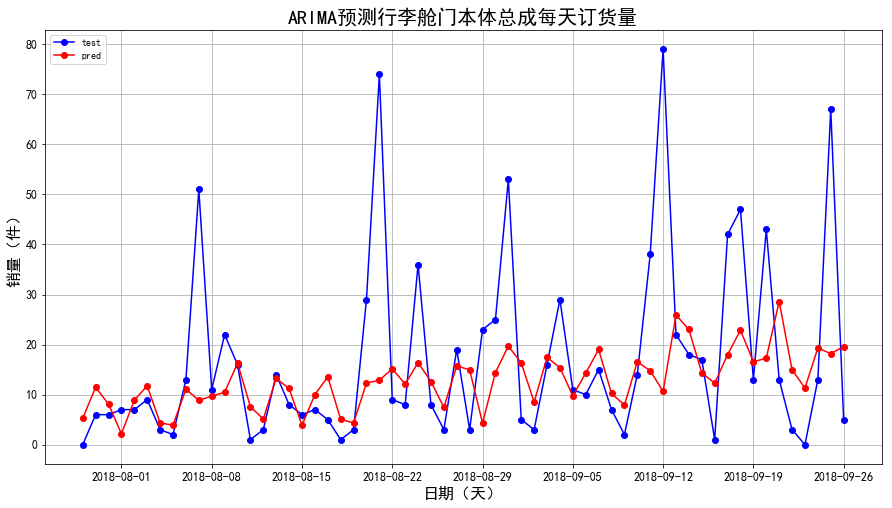

In [23]:
fig, ax = plt.subplots()
ax.plot(test_day.index, test, 'bo-', label='test')
ax.plot(test_day.index, preds, 'ro-', label='pred')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('ARIMA预测行李舱门本体总成每天订货量', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.savefig("../figs/ARIMA预测图.png")
plt.show()

### 3.3 SARIMAX

In [29]:
train, test = train_day.order_num.values, test_day.order_num.values

NameError: name 'train_month' is not defined

In [ ]:
# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 6)

# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 1) for x in pdq]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = SARIMAX(train,
                              order = param,
                              seasonal_order = param_seasonal,
                              enforce_stationarity=True,
                              enforce_invertibility=True)
            res = tmp_mdl.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

In [30]:
history = list(train)
preds = list()
for i in range(len(test)):
    model = SARIMAX(train, order=(5, 0, 4), seasonal_order=(0, 1, 1, 7))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    preds.append(yhat)
    obs = test[i]
    history.append(obs)
    print("expected = %f predicted = %f" % (obs, yhat))
error = sqrt(mean_squared_error(test, preds))
print("Test RMSE: %.3f" % error)

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 444.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 7012.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 5608.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 4344.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 80.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 0.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 1828.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 568.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 1212.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 144.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 396.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 100.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 100.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 308.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 440.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 5136.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 72.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 296.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 172.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 124.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 372.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 3196.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 3584.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 1960.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 992.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 4.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 120.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 0.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 616.000000 predicted = 875.123609
expected = 996.000000 predicted = 875.123609
Test RMSE: 1947.732


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


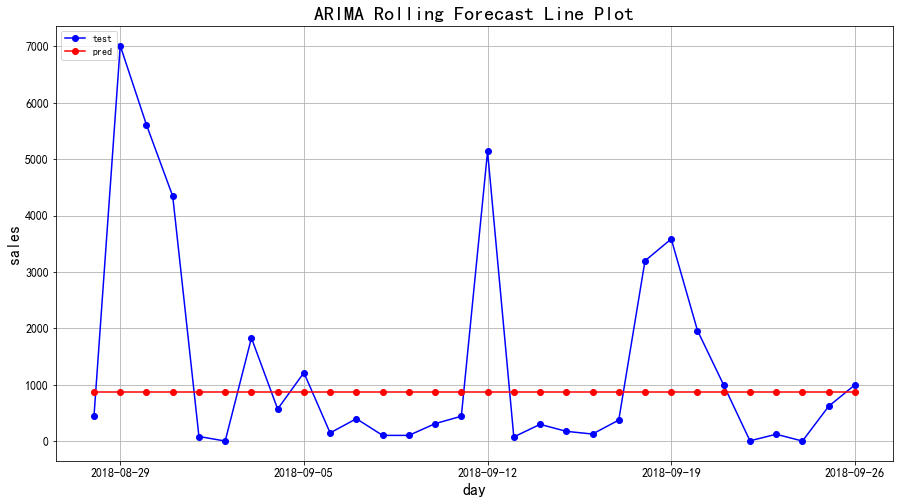

In [31]:
fig, ax = plt.subplots()
ax.plot(test_day.index, test, 'bo-', label='test')
ax.plot(test_day.index, preds, 'ro-', label='pred')
ax.set_xlabel('day', fontsize=16)
ax.set_ylabel('sales', fontsize=16)
ax.set_title('ARIMA Rolling Forecast Line Plot', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.savefig("../figs/ARIMA预测图.png")
plt.show()